In [1]:
import torch
import torchaudio

import torch.nn as nn

import torch.functional as F
import torchaudio.functional as AU

import torchvision.transforms as T
import torchaudio.transforms as AT

import os
import torchaudio.datasets.gtzan as gtzan
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import random_split
from torchmetrics import Accuracy

In [2]:
try:
    os.mkdir("GTZAN_DATA")
except:
    print("GTZAN_DATA directory alread exist")
    
try:
    os.mkdir("models")
except:
    print("models directory alread exist")

GTZAN_DATA directory alread exist
models directory alread exist


In [3]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100%|███████████████████████████████████████| 1.21G/1.21G [38:56<00:00, 113kB/s]
100%|███████████████████████████████████████| 1.21G/1.21G [38:56<00:00, 557kB/s]


In [4]:
!unzip -q gtzan-dataset-music-genre-classification.zip -d GTZAN_DATA

In [5]:
SAMPLE_RATE = 16000
mel_spectrogram = AT.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

In [6]:
gtzan_genres = [
    'blues',
    'classical',
    'country',
    'disco',
    'hiphop',
    'jazz',
    'metal',
    'pop',
    'reggae',
    'rock'
]

In [7]:
class GTZANDataset(torch.utils.data.Dataset):
    def __init__(self, audio_dir, anotations_file, transformations=None):
        self.audio_dir = audio_dir
        self.transformations = transformations
        self.annotations = pd.read_csv(anotations_file)
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        
        path = self._get_audio_sample_path(idx)
        signal, sr = torchaudio.load(path)
        signal = mel_spectrogram(signal)
        label = self._get_audio_sample_label(idx)
        return signal, label
        
    def _get_audio_sample_path(self, index):
        
        name = self.annotations.iloc[index, 0]
        cat, ide, ext = name.split(".")
        
        path = os.path.join(self.audio_dir, cat, name)
        
        return path
    
    def _get_audio_sample_label(self, index):
        
        name = self.annotations.iloc[index, 0]
        cat, ide, ext = name.split(".")
        
        return cat
    
    def view_dataset(self, idx):
        signal, label = self.__getitem__(idx)
        img = T.ToPILImage()(signal)
        return img, label
        

In [8]:
ANNOTATIONS_FILE = "GTZAN_DATA/Data/features_30_sec.csv"
AUDIO_PATH = "GTZAN_DATA/Data/genres_original"

gtzan_dataset = GTZANDataset(AUDIO_PATH,ANNOTATIONS_FILE)

In [9]:
train_size = int(len(gtzan_dataset)*.8)
test_size = len(gtzan_dataset) - train_size
train_dataset, test_dataset = random_split(gtzan_dataset, [train_size, test_size])

In [10]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

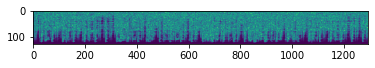

blues
(128, 1293)


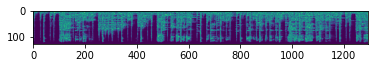

blues
(128, 1293)


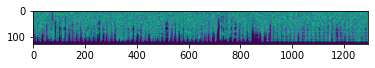

blues
(128, 1293)


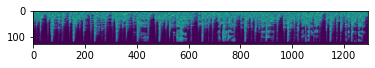

blues
(128, 1293)


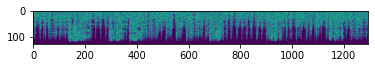

blues
(128, 1293)


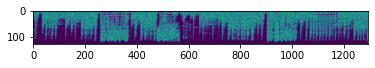

blues
(128, 1293)


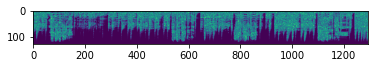

blues
(128, 1293)


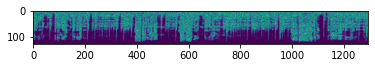

blues
(128, 1293)


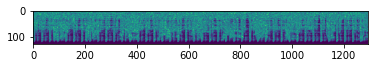

blues
(128, 1293)


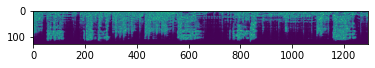

blues
(128, 1293)


In [11]:
for i in range(10):
    img, label = gtzan_dataset.view_dataset(i)
    plt.imshow(img)
    plt.show()
    print(label)
    print(np.array(img).shape)

In [12]:
#122
#1287

In [15]:
from datetime import datetime
from torch.nn.functional import softmax

class Trainer:
    def __init__(self, model, loss_fn, optimizer, metrics=None,
                 metric_names=None,
                 writer=None, path_to_save='',
                 learning_rate = 1e-3,
                 batch_size = 64,
                 epochs = 5, n_report= 1000):
        #################################
        # propiedades de la clase Trainer
        #################################
        # red neuronal
        self.model = model
        # función de pérdida
        self.loss_fn = loss_fn
        # optimizador
        self.optimizer = optimizer
        # métricas
        self.metrics_train = metrics
        self.metrics_valid = self.metrics_train.copy()
        self.metric_names = metric_names
        
        # writer de tensorboard 
        self.writer = writer
        
        # hiperparámetros
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.n_report = n_report
        
        # path para almacenar los modelos
        self.path_to_save = path_to_save
        # path al mejor modelo encontrado
        self.best_model = None
        
        # datos: se cargan desde la función fit
        # datos de entrenamiento
        self.training_loader = None
        # datos de validación
        self.validation_loader = None
     
    ##############################
    #  Métodos de la clase Trainer
    ##############################
    # setters              
    def set_model(self, model):
        self.model = model
    
    def set_loss(self, loss):
        self.loss = loss
        
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def set_writer(self, writer):
        self.writer =  writer
    # getters
    def get_model(self):
        return self.model
    
    
    def set_hiperparameters(self,
                 learning_rate = 1e-3,
                 batch_size = 64,
                 epochs = 5):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs        
    
    ######################################
    # métodos básicos para entrenamiento #
    ######################################
    # paso de entrenamiento
    def _train_one_epoch_(self, epoch_index):
        """
        corre un paso de entrenamiento
        :params
        :epoch_index: índice de la época
        :n_report: cada cuantas iteraciones reportar en pantalla
        """
        running_loss = 0.
        last_loss = 0.
        # Aquí, usamos enumerate(training_loader) en lugar de
        # iter(training_loader) para que podamos rastrear el lote
        # indexar y hacer algunos informes dentro de la época
        for i, data in enumerate(self.training_loader):
            # Cada instancia de datos contiene parejas  input + label 
            inputs, labels = data

            # backpropagation
            # por defecto el cálculo del gradiente es acumulativo
            # comienza colocando el gradiente en cero
            self.optimizer.zero_grad()

            # Hace la predicción para este lote (batch)
            outputs = self.model(inputs)
            predicts = softmax(outputs, dim=-1)

            # Calcula la pérdida y sus gradientes
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            # Ajusta los pesos del modelo 
            # w{i+1} = w{i} + learning_rate * grad(loss)
            self.optimizer.step()

            # Recolecta  datos y los reporta
            # pérdida
            running_loss += loss.item()
            # metricas
            running_metrics = self._metric_step_(predicts, labels, metric_compute=False, 
                                          validation=False)
            
            if i % self.n_report == (self.n_report-1):
                # pérdida
                last_loss = running_loss / self.n_report # pérdida promedio por lote(batch)
                running_loss = 0.
                # métricas
                last_metrics = self._metric_step_(None, None, metric_compute=True, 
                                          validation=False)
                
                # imprime pérdida del lote
                print('Pérdida en el lote {} : {}'.format(i + 1, last_loss))
                
                # imprime métricas del lote
                print_m = ''
                for j in range(len(metrics)):
                    print_m += self.metric_names[j] + ': ' + str(last_metrics[j]) + ' '
                print('Métricas en el lote {} : {}'.format(i + 1, print_m))
                
                # escribe en el writer
                if self.writer is not None:
                    tb_x = epoch_index * len(training_loader) + i + 1
                    # pérdida
                    self.writer.add_scalar('Pérdida/Entrenamiento', last_loss, tb_x)
                    # métricas
                    for i in range(len(last_metric)):
                        self.writer.add_scalar(self.metric.names[i] + '/Entrenamiento', 
                                               last_metrics[i], tb_x)
                        
                
                
    def _validation_step_(self, validation=True):
        """
        corre un paso de validación
        :params: validation=True; toma los datos de validación
        :        sino toda los datos de entrenamiento
        """
        
        if validation:
            data_loader = self.validation_loader
        else:
            data_loader = self.training_loader
        
        # Pérdida
        running_vloss = 0.0   
        for i, vdata in enumerate(data_loader):
            vinputs, vlabels = vdata
            voutputs = self.model(vinputs)
            vpredicts = softmax(voutputs,dim=-1)
            vloss = self.loss_fn(voutputs, vlabels)
            
            running_vloss += vloss
            _  = self._metric_step_(vpredicts, vlabels, 
                            metric_compute=False, validation= validation)

        avg_vloss = running_vloss / (i + 1)
        v_metrics =   self._metric_step_(None, None, metric_compute=True, 
                                          validation= validation)
        
        return avg_vloss, v_metrics
        
    def _metric_step_(self, predicts, labels, metric_compute=False, validation=False):
        """
        actualiza y calcula las métricas
        """            
                
        if validation:
            metrics = self.metrics_valid
        else:
            metrics = self.metrics_train
        
        if predicts is not None and labels is not None:
            for i, metric in enumerate(metrics):
                metrics[i].update(predicts, labels)
        
        if metric_compute:
            values = [metric.compute().item() for metric in metrics]
            for metric in metrics:
                metric.reset() 
        else:
            values = [metric(predicts, labels).item() for metric in metrics]
    
        return values
      
    
    # ciclo de entrenamiento
    def _train_loop_(self):
        # registra marca  de tiempo
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        # contador de epochs
        epoch_number = 0

        # Inicializa la mejor pérdida en un valor muy grande
        # el propósito es mejorar esta mejor pérdida
        best_vloss = 1_000_000.
        
         
        # ciclo de entrenamiento
        for epoch in range(self.epochs):
            print('época {}:'.format(epoch_number + 1))
            
            # paso de entrenamiento
            # coloca en modelo en modo entrenamiento 
            model.train(True)
            # lanza un paso de entrenamiento
            self._train_one_epoch_(epoch_number)

            # paso de validación 
            # coloca el modelo en modo inferencia
            self.model.train(False)
            
            # lanza un paso de validación
            e_loss, e_metrics = self._validation_step_(validation=False)
            v_loss, v_metrics = self._validation_step_(validation=True)
            
            # imprime pérdida dela época
            print('Pérdida entrenamiento: {}, validación {}'.format(e_loss, v_loss))
            
            # imprime métricas del lote la época
            print_m_e = ''
            for i in range(len(e_metrics)):
                print_m_e += self.metric_names[i] + ': ' + str(e_metrics[i]) + ' '
            print_m_v = ''
            for i in range(len(v_metrics)):
                print_m_v += self.metric_names[i] + ': ' + str(v_metrics[i]) + ' '     
            print('Métricas en entrenamiento : {}, validación {} '.format(print_m_e, print_m_v))

            # Registra (log) la pérdida actual promedio  por lote (batch)
            # para entrenamiento y validación
            if self.writer is not None:
                # pérdida
                self.writer.add_scalars('Pérdida entrenamiento v.s. Pérdida validación',
                                { 'Entrenamiento' : e_loss, 'Validación' : e_vloss },
                                epoch_number + 1)
                
                # métricas
                for i in range(len(e_metrics)):  
                    self.writer.add_scalars(self.metric.names[i] + 'entrenamiento v.s. validación',
                                { 'Entrenamiento' : e_metrics[i], 'Validación' : v_metrics[i] },
                                epoch_number + 1)
                  
                self.writer.flush()

            # Realice un seguimiento del mejor rendimiento y guarda el estado del modelo
            if  v_loss < best_vloss:
                best_vloss = v_loss
                model_path = self.path_to_save + 'model_{}_{}'.format(timestamp, epoch_number)
                torch.save(model.state_dict(), model_path)
                self.path_best_model = model_path

            epoch_number += 1 
        """
        calculo final de pérdida y métric no se requiere
        """
       
                    
            
    def fit(self, train_data, val_data, epochs=None, writer=None, best_loss=True):
        if writer is not None:
            self.writer = writer
        if epochs is not None:
            self.epochs = epochs
       # datos de entrenamiento
        self.training_loader = train_data
        # datos de validación
        self.validation_loader = val_data
        
        # lanza loop de entrenamiento
        self._train_loop_()
        # carga al modelo los pesos con mejor pérdida
        if best_loss:
            self.model.load_state_dict(torch.load(self.path_best_model))

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # input (128, 1293)
        self.conv1 = nn.Conv2d(1,8,3)
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(2)
        self.drop1 = nn.Dropout2d()

        self.conv2 = nn.Conv2d(8,32,3)
        self.act2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2)
        self.drop2 = nn.Dropout2d()

        self.conv3 = nn.Conv2d(32,64,3)
        self.act3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2)
        self.drop3 = nn.Dropout2d()
        
        self.ReLU1 = nn.ReLU()
        self.lin1 = nn.Linear(14*159*64,2226)
        self.drop4 = nn.Dropout()
        
        self.ReLU2 = nn.ReLU()
        self.lin2 = nn.Linear(2226,556)
        self.drop5 = nn.Dropout()
        
        self.ReLU3 = nn.ReLU()
        self.lin3 = nn.Linear(556, 128)
        self.drop6 = nn.Dropout()
        
        self.Soft = nn.Softmax(dim=0)
        self.lin4 = nn.Linear(128, 10)
        self.drop7 = nn.Dropout()
        
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.act1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.act2(x)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.act3(x)
        x = self.drop3(x)
        
        x = torch.flatten(x)
        
        x = self.lin1(x)
        x = self.ReLU1(x)
        x = self.drop4(x)
        
        x = self.lin2(x)
        x = self.ReLU2(x)
        x = self.drop5()
        
        x = self.lin3(x)
        x = self.ReLU3(x)
        x = self.drop6(x)
        
        x = self.lin4(x)
        x = self.drop7(x)
        
        x = self.Soft(x)
        
        return x  

In [17]:
red = Discriminator()
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(red.parameters(), lr=0.001)

metrics = [Accuracy()]

metric_names = ['Exactitud']

path_to_save = './models'

trainer = Trainer(red, loss, opt, metrics, metric_names, path_to_save=path_to_save)

In [18]:
trainer.train()

AttributeError: 'Trainer' object has no attribute 'train'